In [1]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


1. Загрузка данных
2. Предобработка + fe (используем все столбцы, кроме столбцов с пропусками) для числовых столбцов:
* Удаление выбросов вручную - глянуть как (скорей всего замена на какое-то странное значение)
* Расчет порогов (огрубление шкал): для отдельных шкал (например, возраст больше 40 лет), для сочетания шкал (например, женщины старше 50 лет - в общем, группы риска)
* Расчет индекса массы тела
* Расчет риска ССЗ (относит + SCORE)

# 1. Загрузка данных

In [2]:
train = pd.read_csv('./data/train.csv', header=0, sep=';')
test = pd.read_csv('./data/test.csv', header=0, sep=';')

In [3]:
print train.shape
print test.shape

(70000, 13)
(30000, 12)


In [4]:
train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# 2. Удаление выбросов и огрубление шкал

## 2.1 Возраст

Добавим возраст в годах.

In [5]:
train['age_year'] = train['age']/365.0
test['age_year'] = test['age']/365.0

Сделаем два дополнительных бинарных поля: возраст превышает 60 и возраст меньше 40.

In [6]:
train['age_over_60'] = train['age_year'].apply(lambda x: 1 if x>60 else 0)
test['age_over_60'] = test['age_year'].apply(lambda x: 1 if x>60 else 0)

train['age_less_40'] = train['age_year'].apply(lambda x: 1 if x<40 else 0)
test['age_less_40'] = test['age_year'].apply(lambda x: 1 if x<40 else 0)

## 2.2 Вес

Еслив вес меньше 40, то меняем на 40.

In [7]:
train['weight'] = train['weight'].apply(lambda x: 40 if x<40 else x)
test['weight'] = test['weight'].apply(lambda x: 40 if x<40 else x)

Создаем дополнительное поле - вес больше 90.

In [8]:
train['weight_over_90'] = train['weight'].apply(lambda x: 1 if x>90 else 0)
test['weight_over_90'] = test['weight'].apply(lambda x: 1 if x>90 else 0)

Создаем еще два дополнительных признака в зависимости от пола: пол женский (gender == 1) и вес больше 85, пол мужской (gender == 2) и вес больше 100.

In [9]:
train['weight_male_over_100'] = train.apply(lambda x: 1 if x.gender==2 and x.weight>100 else 0, axis=1)
test['weight_male_over_100'] = test.apply(lambda x: 1 if x.gender==2 and x.weight>100 else 0, axis=1)

train['weight_female_over_100'] = train.apply(lambda x: 1 if x.gender==1 and x.weight>85 else 0, axis=1)
test['weight_female_over_100'] = test.apply(lambda x: 1 if x.gender==1 and x.weight>85 else 0, axis=1)

## 2.3 Рост

Если рост меньше 140, то меняем на 140.

In [10]:
train['height'] = train['height'].apply(lambda x: 140 if x<140 else x)
test['height'] = test['height'].apply(lambda x: 140 if x<140 else x)

## 2.4 Верхнее давление (систолическое) и  нижнее (диастолическое)

Если давление отрицательное, то считаем это опечаткой и просто умножаем на -1.

In [11]:
train['ap_hi'] = train['ap_hi'].apply(lambda x: -x if x<0 else x)
test['ap_hi'] = test['ap_hi'].apply(lambda x: -x if x<0 else x)

train['ap_lo'] = train['ap_lo'].apply(lambda x: -x if x<0 else x)
test['ap_lo'] = test['ap_lo'].apply(lambda x: -x if x<0 else x)

Если верхнее давление меньше 70 или больше 250, то заменяем его на среднее по выборке.

In [12]:
ap_hi_mean = train['ap_hi'].mean()

train['ap_hi'] = train['ap_hi'].apply(lambda x: ap_hi_mean if x<70 or x>250 else x)
test['ap_hi'] = test['ap_hi'].apply(lambda x: ap_hi_mean if x<70 or x>250 else x)

Если нижнее давление меньше 40 или больше 200, то заменяем его на среднее по выборке.

In [13]:
ap_lo_mean = train['ap_lo'].mean()

train['ap_lo'] = train['ap_lo'].apply(lambda x: ap_lo_mean if x<40 or x>200 else x)
test['ap_lo'] = test['ap_lo'].apply(lambda x: ap_lo_mean if x<40 or x>200 else x)

Посмотрим на объекты, где дистолическое давление выше систолического.

In [14]:
train[train.ap_lo > train.ap_hi][['ap_hi', 'ap_lo']].count()

ap_hi    107
ap_lo    107
dtype: int64

Для таких объектов просто поменяем их местами.

In [15]:
# создаем копию для столбца верхнего давления
train['ap_hi_copy'] = train['ap_hi']
test['ap_hi_copy'] = test['ap_hi']

# меняем значения в ap_hi на значения в ap_lo, если они меньше в ap_lo
train['ap_hi'] = train.apply(lambda x: x.ap_lo if x.ap_hi<x.ap_lo else x.ap_hi, axis=1)
test['ap_hi'] = test.apply(lambda x: x.ap_lo if x.ap_hi<x.ap_lo else x.ap_hi, axis=1)

# меняем значения в ap_lo, если они больше значений ap_hi_copy
train['ap_lo'] = train.apply(lambda x: x.ap_hi_copy if x.ap_lo>x.ap_hi_copy else x.ap_lo, axis=1)
test['ap_lo'] = test.apply(lambda x: x.ap_hi_copy if x.ap_lo>x.ap_hi_copy else x.ap_lo, axis=1)

#удаляем столбцы с копиями
train.drop('ap_hi_copy', axis=1, inplace=True)
test.drop('ap_hi_copy', axis=1, inplace=True)

Создаем дополнительный признак: верхнее давление выше 140.
На будущее: верхнее давление также зависит от пола и возраста и можно создать подобные признаки.

In [16]:
train['ap_hi_over_140'] = train['ap_hi'].apply(lambda x: 1 if x>140 else 0)
test['ap_hi_over_140'] = test['ap_hi'].apply(lambda x: 1 if x>140 else 0)

Создаем дополнительный признак: нижнее давление выше 95. 

In [17]:
train['ap_lo_over_95'] = train['ap_lo'].apply(lambda x: 1 if x>95 else 0)
test['ap_lo_over_95'] = test['ap_lo'].apply(lambda x: 1 if x>95 else 0)

In [18]:
train.head().T

,0,1,2,3,4
id,0.000000,1.000000,2.000000,3.000000,4.000000
age,18393.000000,20228.000000,18857.000000,17623.000000,17474.000000
gender,2.000000,1.000000,1.000000,2.000000,1.000000
height,168.000000,156.000000,165.000000,169.000000,156.000000
weight,62.000000,85.000000,64.000000,82.000000,56.000000
ap_hi,110.000000,140.000000,130.000000,150.000000,100.000000
ap_lo,80.000000,90.000000,70.000000,100.000000,60.000000
cholesterol,1.000000,3.000000,3.000000,1.000000,1.000000
gluc,1.000000,1.000000,1.000000,1.000000,1.000000
smoke,0.000000,0.000000,0.000000,0.000000,0.000000


## 2.5 Индекс массы тела (BMI)

Рассчитывается как https://ru.wikipedia.org/wiki/Индекс_массы_тела.

In [19]:
train['BMI'] = train.apply(lambda x: (x.weight)/((x.height/100)**2), axis=1)
test['BMI'] = test.apply(lambda x: (x.weight)/((x.height/100)**2), axis=1)

Посмотрим на полученные характеристики индекса.

In [20]:
train['BMI'].describe()

count    70000.000000
mean        27.491019
std          5.274661
min         12.624669
25%         23.875115
50%         26.370238
75%         30.222222
max         90.816327
Name: BMI, dtype: float64

Вообще, судя по среднему значению, средний человек находится в состоянии предожирения.

Вообще конечно ИМТ зависит от возраста и пола, но мы возьмем по шкале ВОЗ > 35 (ожирение 2 степени).

In [21]:
train['BMI_over_35'] = train['BMI'].apply(lambda x: 1 if x>35 else 0)
test['BMI_over_35'] = test['BMI'].apply(lambda x: 1 if x>35 else 0)

Рассчитаем еще один индекс массы тела - индекс Брейтмана:  Нормальная масса тела рассчитывается по формуле — рост [см] • 0,7 — 50 кг. 
Рассчитаем как разницу между массой тела и нормальнйо массой по индексу Брейтмана.

In [22]:
train['BMI_Breitman'] = train.apply(lambda x: x.weight-(x.height*0.7-50), axis=1)
test['BMI_Breitman'] = test.apply(lambda x: x.weight-(x.height*0.7-50), axis=1)

## 2.6 Расчет риска ССЗ

Для расчета будем использовать усеченную модель SCORE (после 40 лет) и шкалу относительного риска https://www.gnicpm.ru/UserFiles/Metod._rekomendacii_po_dispanserizacii__2_izdanie__10_часть%201.pdf.

В риске учитываются следующие параметры:
* возраст
* верхний уровень давления
* концентрация холестерина
* пол

Будем предполагать, что все некурящие.

In [23]:
def risk_cd(x):
    if x.age_year > 65:
        # расчет риска для женщин
        if x.gender == 1 and x.ap_hi > 180 and x.cholesterol == 3:
            return 12
        elif x.gender == 1 and x.ap_hi > 180 and x.cholesterol in (1,2):
            return 8
        elif x.gender == 1 and x.ap_hi > 160 and x.cholesterol == 3:
            return 8
        elif x.gender == 1 and x.ap_hi > 160 and x.cholesterol in (1,2):
            return 6
        elif x.gender == 1 and x.ap_hi > 140 and x.cholesterol == 3:
            return 6
        elif x.gender == 1 and x.ap_hi > 140 and x.cholesterol in (1,2):
            return 4
        elif x.gender == 1 and x.ap_hi > 120 and x.cholesterol == 3:
            return 4
        elif x.gender == 1:
            return 2
        # расчет риска для мужчин
        elif x.gender == 2 and x.ap_hi > 180 and x.cholesterol == 3:
            return 26
        elif x.gender == 2 and x.ap_hi > 180 and x.cholesterol in (1,2):
            return 19
        elif x.gender == 2 and x.ap_hi > 160 and x.cholesterol == 3:
            return 16
        elif x.gender == 2 and x.ap_hi > 160 and x.cholesterol in (1,2):
            return 13
        elif x.gender == 2 and x.ap_hi > 140 and x.cholesterol == 3:
            return 13
        elif x.gender == 2 and x.ap_hi > 140 and x.cholesterol in (1,2):
            return 9
        elif x.gender == 2 and x.ap_hi > 120 and x.cholesterol == 3:
            return 9
        elif x.gender == 2:
            return 6
    elif x.age_year > 60:
        # расчет риска для женщин
        if x.gender == 1 and x.ap_hi > 180 and x.cholesterol == 3:
            return 7
        elif x.gender == 1 and x.ap_hi > 180 and x.cholesterol in (1,2):
            return 5
        elif x.gender == 1 and x.ap_hi > 160 and x.cholesterol == 3:
            return 5
        elif x.gender == 1 and x.ap_hi > 160 and x.cholesterol in (1,2):
            return 3
        elif x.gender == 1 and x.ap_hi > 140 and x.cholesterol == 3:
            return 3
        elif x.gender == 1 and x.ap_hi > 140 and x.cholesterol in (1,2):
            return 2
        elif x.gender == 1 and x.ap_hi > 120 and x.cholesterol == 3:
            return 2
        elif x.gender == 1:
            return 1
        # расчет риска для мужчин
        elif x.gender == 2 and x.ap_hi > 180 and x.cholesterol == 3:
            return 18
        elif x.gender == 2 and x.ap_hi > 180 and x.cholesterol in (1,2):
            return 13
        elif x.gender == 2 and x.ap_hi > 160 and x.cholesterol == 3:
            return 12
        elif x.gender == 2 and x.ap_hi > 160 and x.cholesterol in (1,2):
            return 9
        elif x.gender == 2 and x.ap_hi > 140 and x.cholesterol == 3:
            return 9
        elif x.gender == 2 and x.ap_hi > 140 and x.cholesterol in (1,2):
            return 6
        elif x.gender == 2 and x.ap_hi > 120 and x.cholesterol == 3:
            return 6
        elif x.gender == 2:
            return 4
    elif x.age_year > 55:
        # расчет риска для женщин
        if x.gender == 1 and x.ap_hi > 180 and x.cholesterol == 3:
            return 4
        elif x.gender == 1 and x.ap_hi > 180 and x.cholesterol in (1,2):
            return 3
        elif x.gender == 1 and x.ap_hi > 160 and x.cholesterol == 3:
            return 3
        elif x.gender == 1 and x.ap_hi > 160 and x.cholesterol in (1,2):
            return 2
        elif x.gender == 1 and x.ap_hi > 140 and x.cholesterol == 3:
            return 2
        elif x.gender == 1:
            return 1
        # расчет риска для мужчин
        elif x.gender == 2 and x.ap_hi > 180 and x.cholesterol == 3:
            return 12
        elif x.gender == 2 and x.ap_hi > 180 and x.cholesterol in (1,2):
            return 8
        elif x.gender == 2 and x.ap_hi > 160 and x.cholesterol == 3:
            return 8
        elif x.gender == 2 and x.ap_hi > 160 and x.cholesterol in (1,2):
            return 6
        elif x.gender == 2 and x.ap_hi > 140 and x.cholesterol == 3:
            return 6
        elif x.gender == 2 and x.ap_hi > 140 and x.cholesterol in (1,2):
            return 4
        elif x.gender == 2 and x.ap_hi > 120 and x.cholesterol == 3:
            return 4
        elif x.gender == 2:
            return 2
    elif x.age_year > 50:
        # расчет риска для женщин
        if x.gender == 1 and x.ap_hi > 180 and x.cholesterol == 3:
            return 2
        elif x.gender == 1 and x.ap_hi > 180 and x.cholesterol in (1,2):
            return 1
        elif x.gender == 1 and x.ap_hi > 160 and x.cholesterol == 3:
            return 1
        elif x.gender == 1 and x.ap_hi > 160 and x.cholesterol in (1,2):
            return 1
        elif x.gender == 1 and x.ap_hi > 140 and x.cholesterol == 3:
            return 1
        elif x.gender == 1:
            return 0
        # расчет риска для мужчин
        elif x.gender == 2 and x.ap_hi > 180 and x.cholesterol == 3:
            return 7
        elif x.gender == 2 and x.ap_hi > 180 and x.cholesterol in (1,2):
            return 5
        elif x.gender == 2 and x.ap_hi > 160 and x.cholesterol == 3:
            return 5
        elif x.gender == 2 and x.ap_hi > 160 and x.cholesterol in (1,2):
            return 3
        elif x.gender == 2 and x.ap_hi > 140 and x.cholesterol == 3:
            return 3
        elif x.gender == 2 and x.ap_hi > 140 and x.cholesterol in (1,2):
            return 2
        elif x.gender == 2 and x.ap_hi > 120 and x.cholesterol == 3:
            return 2
        elif x.gender == 2:
            return 1
    elif x.age_year > 40:
        # расчет риска для женщин
        if x.gender == 1:
            return 0
        # расчет риска для мужчин
        elif x.gender == 2 and x.ap_hi > 180 and x.cholesterol == 3:
            return 1
        elif x.gender == 2:
            return 0
    else:
        return 0

In [24]:
train['risk_cd'] = train.apply(risk_cd, axis=1)
test['risk_cd'] = test.apply(risk_cd, axis=1)

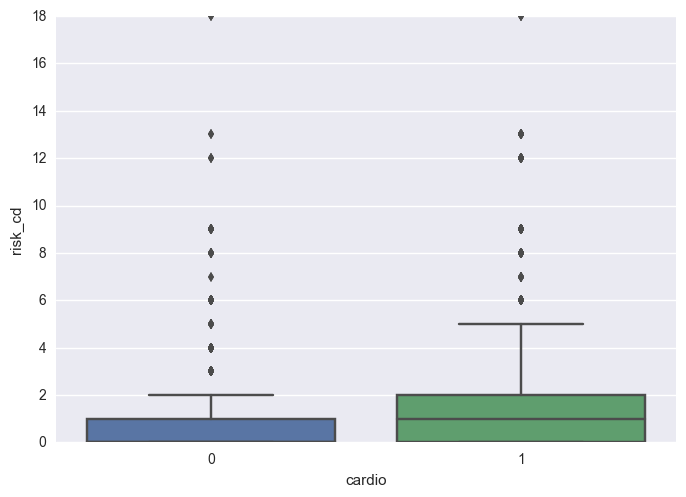

In [25]:
import seaborn as sns

sns.boxplot(x='cardio', y='risk_cd', data=train)

## 2.7 Восстановление значенией smoke

In [26]:
print train.smoke.value_counts()
print test.smoke.value_counts()

0    63831
1     6169
Name: smoke, dtype: int64
0       24601
None     3030
1        2369
Name: smoke, dtype: int64


Итак, пропущено в 3030 записях в test-е.

Заполним это поле нулями.

In [27]:
test['smoke'] = test['smoke'].apply(lambda x: '0' if x=='None' else x)

In [28]:
test['smoke'].value_counts()

0    27631
1     2369
Name: smoke, dtype: int64

## 2.8 Восстановление значений active

In [29]:
print train.active.value_counts()
print test.active.value_counts()

1    56261
0    13739
Name: active, dtype: int64
1       21843
0        5260
None     2897
Name: active, dtype: int64


In [30]:
test['active'] = test['active'].apply(lambda x: '0' if x=='None' else x)
test['active'].value_counts()

1    21843
0     8157
Name: active, dtype: int64

## 2.9 Восстановление значений alco

In [31]:
print train.alco.value_counts()
print test.alco.value_counts()

0    66236
1     3764
Name: alco, dtype: int64
0       25500
None     3031
1        1469
Name: alco, dtype: int64


In [32]:
test['alco'] = test['alco'].apply(lambda x: '0' if x=='None' else x)
test['alco'].value_counts()

0    28531
1     1469
Name: alco, dtype: int64

## 2.10 Кластеризация

Попробуем кластеризовать всех пациентов.
0. Данные предварительно склеиваем
1. Кластеризуем с помощью всех признаков (кроме cardio) - эксперименты с силуэтом
2. Выбираем количество кластеров
3. Разбиваем на это количество
4. делаем тоже самое для тестовой выборки

In [33]:
all_data = pd.concat([train.drop('cardio', axis=1), test])

In [34]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans

In [41]:
def agglomerative_experiment(data, n_clusters):
    silhoutte_scores = []

    for n in n_clusters:
        # создаем модель
        clm1 = MiniBatchKMeans(n_clusters=n, max_iter=50, random_state=11)
        labels = clm1.fit_predict(data)
        
        sc1 = silhouette_score(data, labels, metric='euclidean', sample_size=5000)
        silhoutte_scores.append(sc1)

        print sc1

    plt.plot(n_clusters, silhoutte_scores)
    plt.title(title)
    plt.xlabel(u'Количество кластеров')
    plt.ylabel(u'Метрика силуэта')

0.59305536107
0.579847516204
0.584628894947
0.5679878243
0.557215857993
0.582283838444
0.563656292605
0.579151637447
0.585598231374
0.667891258153
0.693006365455
0.72901242454
0.701009669932
0.691800509845
0.660396776747
0.637137059175
0.625777143923
0.610621591076


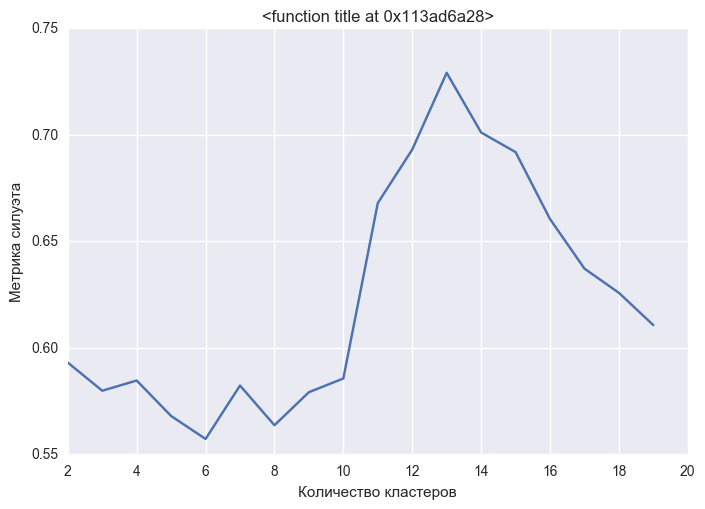

In [42]:
n_clusters=range(2,20)
agglomerative_experiment(train[['age', 'weight', 'height', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']], n_clusters)

Создаем 13 кластеров и добавляем их лейблы в данные.

In [44]:
clm1 = MiniBatchKMeans(n_clusters=13, max_iter=100, random_state=11)
labels = clm1.fit_predict(train[['age', 'weight', 'height', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']])
train['cluster'] = labels

labels_test = clm1.predict(test[['age', 'weight', 'height', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']])
test['cluster'] = labels_test

# 3. Сохраняем данные

In [45]:
print train.shape
print test.shape

(70000, 26)
(30000, 25)


In [46]:
train.to_csv('./data/train_fe_2806.csv', header=True, index=False, sep=';')
test.to_csv('./data/test_fe_2806.csv', header=True, index=False, sep=';')